In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, Input, Activation)
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report

2025-06-28 19:24:24.772176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751138665.005030      73 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751138665.073432      73 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (256, 256)
# ROOT_DIR = "datasets/dataset_split"
ROOT_DIR = "/kaggle/input/turbine-blades-2/dataset_split/dataset_split"

In [3]:
# Mengambil nama-nama kelas dari direktori
CLASS_NAMES = ['ablation', 'breakdown', 'fracture', 'groove']

# Membuat mapping dari nama kelas ke indeks
CLASS_TO_INDEX = {name: index for index, name in enumerate(CLASS_NAMES)}

# Menghitung jumlah kelas
NUM_CLASSES = len(CLASS_NAMES) + 1

# Load data

In [4]:
def load_image_mask(image_path, mask_path):
    # Gambar dibaca, di-decode, dan di-resize (format PNG).
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # Standardisasi ke rentang 0.0 - 1.0
    img = tf.cast(img, tf.float32) / 255.0

    # Mask dibaca, di-decode, dan di-resize.
    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, IMG_SIZE, method='nearest')
    msk = tf.cast(msk, tf.int32)  # pastikan integer
    
    # Ubah mask ke one-hot sesuai NUM_CLASSES
    msk = tf.squeeze(msk, axis=-1)
    msk = tf.one_hot(msk, depth=NUM_CLASSES)
    return img, msk

In [5]:
def get_dataset(split_dir, batch_size=8, shuffle=True):
    img_dir = os.path.join(split_dir, 'images')
    mask_dir = os.path.join(split_dir, 'masks')
    
    img_files = set([
        f for f in os.listdir(img_dir)
        if not (f.startswith('.') or f.startswith('._')) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    mask_files = set([
        f for f in os.listdir(mask_dir)
        if not (f.startswith('.') or f.startswith('._')) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    
    common_files = sorted(list(img_files & mask_files))
    img_paths = [os.path.join(img_dir, f) for f in common_files]
    mask_paths = [os.path.join(mask_dir, f) for f in common_files]
    print(f"Jumlah data di {split_dir}: {len(img_paths)}")
    
    assert len(img_paths) == len(mask_paths), f"Jumlah gambar ({len(img_paths)}) dan mask ({len(mask_paths)}) tidak sama!"
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(100, seed=42)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [6]:
# Load dataset
train_ds = get_dataset(f'{ROOT_DIR}/train', batch_size=8,shuffle=True)
val_ds = get_dataset(f'{ROOT_DIR}/val', batch_size=8, shuffle=False)
test_ds = get_dataset(f'{ROOT_DIR}/test', batch_size=8, shuffle=False)

Jumlah data di /kaggle/input/turbine-blades-2/dataset_split/dataset_split/train: 810


I0000 00:00:1751138685.488316      73 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Jumlah data di /kaggle/input/turbine-blades-2/dataset_split/dataset_split/val: 227
Jumlah data di /kaggle/input/turbine-blades-2/dataset_split/dataset_split/test: 112


# Arsitektur

## Transunet Recurrent

In [33]:
def recurrent_block(x, filters, t=2, dropout_rate=0.5):
    for i in range(t):
        if i == 0:
            x1 = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
            # x1 = layers.Dropout(dropout_rate)(x1)  # Dropout ditambahkan setelah Conv2D pertama
        else:
            x1 = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(layers.Add()([x, x1]))
            x1 = layers.BatchNormalization()(x1)
            # x1 = layers.Dropout(dropout_rate)(x1)  # Dropout ditambahkan setelah BatchNorm
            return x1

def rcnn_block(x, filters, t=2):
# Konversi input x ke jumlah channel = filters jika tidak sama
    if x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, padding='same')(x)
        x1 = recurrent_block(x, filters, t)
        x2 = recurrent_block(x1, filters, t)
        out = layers.Add()([x, x2])
        return out

def transformer_block(x, num_heads=4, ff_dim=512):
    B, H, W, C = x.shape
    x_flat = layers.Reshape((H * W, C))(x)
    
    # LayerNorm + MHA
    attn_input = layers.LayerNormalization(epsilon=1e-6)(x_flat)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=C // num_heads)(attn_input, attn_input)
    x = x_flat + attn_output  # Residual connection

    # FFN   
    ffn_input = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn_output = layers.Dense(ff_dim, activation='relu')(ffn_input)
    ffn_output = layers.Dense(C)(ffn_output)
    x = x + ffn_output  # Residual connection

    return layers.Reshape((H, W, C))(x)


In [34]:
def transunet_with_rcnn(input_size=(256, 256, 3), num_classes=NUM_CLASSES, num_heads=4, ff_dim=512):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = rcnn_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = rcnn_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = rcnn_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = rcnn_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck with Transformer
    conv5 = rcnn_block(pool4, 512)
    trans = transformer_block(conv5, num_heads=num_heads, ff_dim=ff_dim)

    # Decoder
    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(trans), conv4], axis=-1)
    conv6 = rcnn_block(up6, 256)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=-1)
    conv7 = rcnn_block(up7, 128)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
    conv8 = rcnn_block(up8, 64)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=-1)
    conv9 = rcnn_block(up9, 32)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=outputs, name="Transunet")


# Metrix dan Callback

## Callback

In [9]:
earlystopping = EarlyStopping(monitor='val_dsc', patience=10, mode='max',
                              verbose=1, restore_best_weights=True, min_delta=1e-6)

reduce_lr = ReduceLROnPlateau(monitor='val_dsc', factor=0.5, patience=3, mode='max', verbose=2)

transunet_checkpoint = ModelCheckpoint(
    filepath='model/transunet.keras',
    monitor='val_dsc',
    mode='max',
    save_best_only=True,
    verbose=1
)

## Metrix

In [10]:
NUM_CLASSES = 5
IMG_SIZE = (256, 256)  # atau sesuai ukuran kamu
EPOCHS = 100

## IOU

In [11]:
def iou(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

### Dice Coef

In [12]:
def dsc(y_true, y_pred, smooth=1e-6):
    """
    Multi-class Dice Coefficient.
    y_true, y_pred: shape (batch, H, W, C), one-hot encoded.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2])
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

### Dice loss

In [13]:
def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

### BCE loss

In [14]:
def bce_dice_loss(y_true, y_pred):
    loss = categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

### Tversky loss

In [15]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    y_true_pos =  tf.keras.backend.flatten(y_true)
    y_pred_pos =  tf.keras.backend.flatten(y_pred)
    true_pos =  tf.keras.backend.sum(y_true_pos * y_pred_pos)
    false_neg =  tf.keras.backend.sum(y_true_pos * (1 - y_pred_pos))
    false_pos =  tf.keras.backend.sum((1 - y_true_pos) * y_pred_pos)
    return 1 - (true_pos + 1e-6) / (true_pos + alpha * false_neg + beta * false_pos + 1e-6)


### Weigted + Dice loss

In [16]:
CLASS_WEIGHTS = [0.05, 1.5, 2.0, 3.0, 4.0]

In [17]:
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # untuk menghindari log(0)
        loss = y_true * tf.math.log(y_pred) * weights
        return -tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    
    return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - tf.reduce_mean(dice)

def combined_loss(weights, alpha=0.5):
    """
    weights: list of class weights (e.g., [0.1, 2.0, 2.5, 3.0, 4.0])
    alpha: balance factor between crossentropy and dice loss
    """
    wce = weighted_categorical_crossentropy(weights)

    def loss(y_true, y_pred):
        return alpha * wce(y_true, y_pred) + (1 - alpha) * dice_loss(y_true, y_pred)
    
    return loss

### Focal loss

In [18]:
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[1,2,3])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[1,2,3])
    
    tversky = (tp + smooth) / (tp + alpha*fn + beta*fp + smooth)
    return tf.reduce_mean(tf.pow((1 - tversky), gamma))

### Focal tversky + weighted loss

In [19]:
loss = lambda y_true, y_pred: 0.4 * weighted_categorical_crossentropy(CLASS_WEIGHTS)(y_true, y_pred) + 0.6 * focal_tversky_loss(y_true, y_pred)

# Compile model

In [38]:
model_transunet_unet = transunet_with_rcnn(num_heads=4, ff_dim=1026)
model_transunet_unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    # loss=categorical_crossentropy,
    # loss=bce_dice_loss,
    # loss=loss_fn,
    loss=combined_loss(CLASS_WEIGHTS, alpha=0.4),
    # loss=focal_tversky_loss,
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        dsc,
        iou
    ]
)

# Training

## Transformer Unet Recurrent

In [39]:
history_transunet_unet = model_transunet_unet.fit(train_ds, validation_data=val_ds,
                    epochs=EPOCHS, callbacks=[earlystopping, reduce_lr], verbose=1)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - accuracy: 0.6198 - dsc: 0.1468 - iou: 0.1207 - loss: 0.3132 - val_accuracy: 0.9904 - val_dsc: 0.1950 - val_iou: 0.1861 - val_loss: 0.0731 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.9825 - dsc: 0.2137 - iou: 0.2030 - loss: 0.0662 - val_accuracy: 0.9927 - val_dsc: 0.1996 - val_iou: 0.1985 - val_loss: 0.0480 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.9846 - dsc: 0.2207 - iou: 0.2073 - loss: 0.0572 - val_accuracy: 0.9927 - val_dsc: 0.2003 - val_iou: 0.1989 - val_loss: 0.0501 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.9855 - dsc: 0.2245 - iou: 0.2096 - loss: 0.0568 - val_accuracy: 0.9927 - val_dsc: 0.2025 - val_iou: 0.1999 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.9857 - dsc: 0.2313 - iou: 0.2133 -

# Tuning

In [35]:
# Daftar kombinasi yang ingin diuji
num_heads_list = [2, 4, 8]
ff_dim_list = [256, 512, 1024]
EPOCHS_SHORT = 15  # Training singkat
results = []

In [36]:
for num_heads in num_heads_list:
    for ff_dim in ff_dim_list:
        print(f"Training dengan num_heads={num_heads}, ff_dim={ff_dim}")
        
        # Modifikasi fungsi transunet_with_rcnn agar menerima parameter num_heads dan ff_dim
        model = transunet_with_rcnn(num_heads=num_heads, ff_dim=ff_dim)
        model.compile(
            optimizer=Adam(learning_rate=1e-4),
            loss=combined_loss(CLASS_WEIGHTS, alpha=0.4),
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                dsc,
                iou
            ]
        )
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS_SHORT,
            callbacks=[earlystopping, reduce_lr],
            verbose=1
        )
        # Simpan hasil akhir val_dsc dan val_iou
        best_val_dsc = max(history.history['val_dsc'])
        best_val_iou = max(history.history['val_iou'])
        results.append({
            'num_heads': num_heads,
            'ff_dim': ff_dim,
            'best_val_dsc': best_val_dsc,
            'best_val_iou': best_val_iou
        })

Training dengan num_heads=2, ff_dim=256
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 357ms/step - accuracy: 0.6853 - dsc: 0.1579 - iou: 0.1349 - loss: 0.2725 - val_accuracy: 0.9927 - val_dsc: 0.1986 - val_iou: 0.1947 - val_loss: 0.0499 - learning_rate: 1.0000e-04
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.9829 - dsc: 0.2116 - iou: 0.2021 - loss: 0.0612 - val_accuracy: 0.9927 - val_dsc: 0.2000 - val_iou: 0.1979 - val_loss: 0.0418 - learning_rate: 1.0000e-04
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.9811 - dsc: 0.2127 - iou: 0.2022 - loss: 0.0621 - val_accuracy: 0.9927 - val_dsc: 0.2007 - val_iou: 0.1990 - val_loss: 0.0448 - learning_rate: 1.0000e-04
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.9839 - dsc: 0.2220 - iou: 0.2080 - loss: 0.0541 - val_accuracy: 0.9927 - val_dsc: 0.2024 - val_iou: 0.2000 - val_loss: 0.0449 - learning_rate: 1.0000e-04
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0

In [37]:
# Tampilkan hasil grid search
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='best_val_dsc', ascending=False))

   num_heads  ff_dim  best_val_dsc  best_val_iou
5          4    1024      0.247061      0.227573
0          2     256      0.237442      0.220885
1          2     512      0.233389      0.218261
2          2    1024      0.231412      0.217195
4          4     512      0.224500      0.212835
3          4     256      0.224362      0.212475
8          8    1024      0.222130      0.211390
7          8     512      0.220369      0.210232
6          8     256      0.212577      0.205666


# Grafik Training

In [40]:
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(16, 10))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficient
    plt.subplot(2, 2, 3)
    plt.plot(history.history['dsc'], label='Train DSC')
    plt.plot(history.history['val_dsc'], label='Val DSC')
    plt.title(f"{title} - Dice Coefficient")
    plt.xlabel('Epochs')
    plt.ylabel('DSC')
    plt.legend()

    # Plot IoU
    plt.subplot(2, 2, 4)
    plt.plot(history.history['iou'], label='Train IoU')
    plt.plot(history.history['val_iou'], label='Val IoU')
    plt.title(f"{title} - Intersection over Union (IoU)")
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

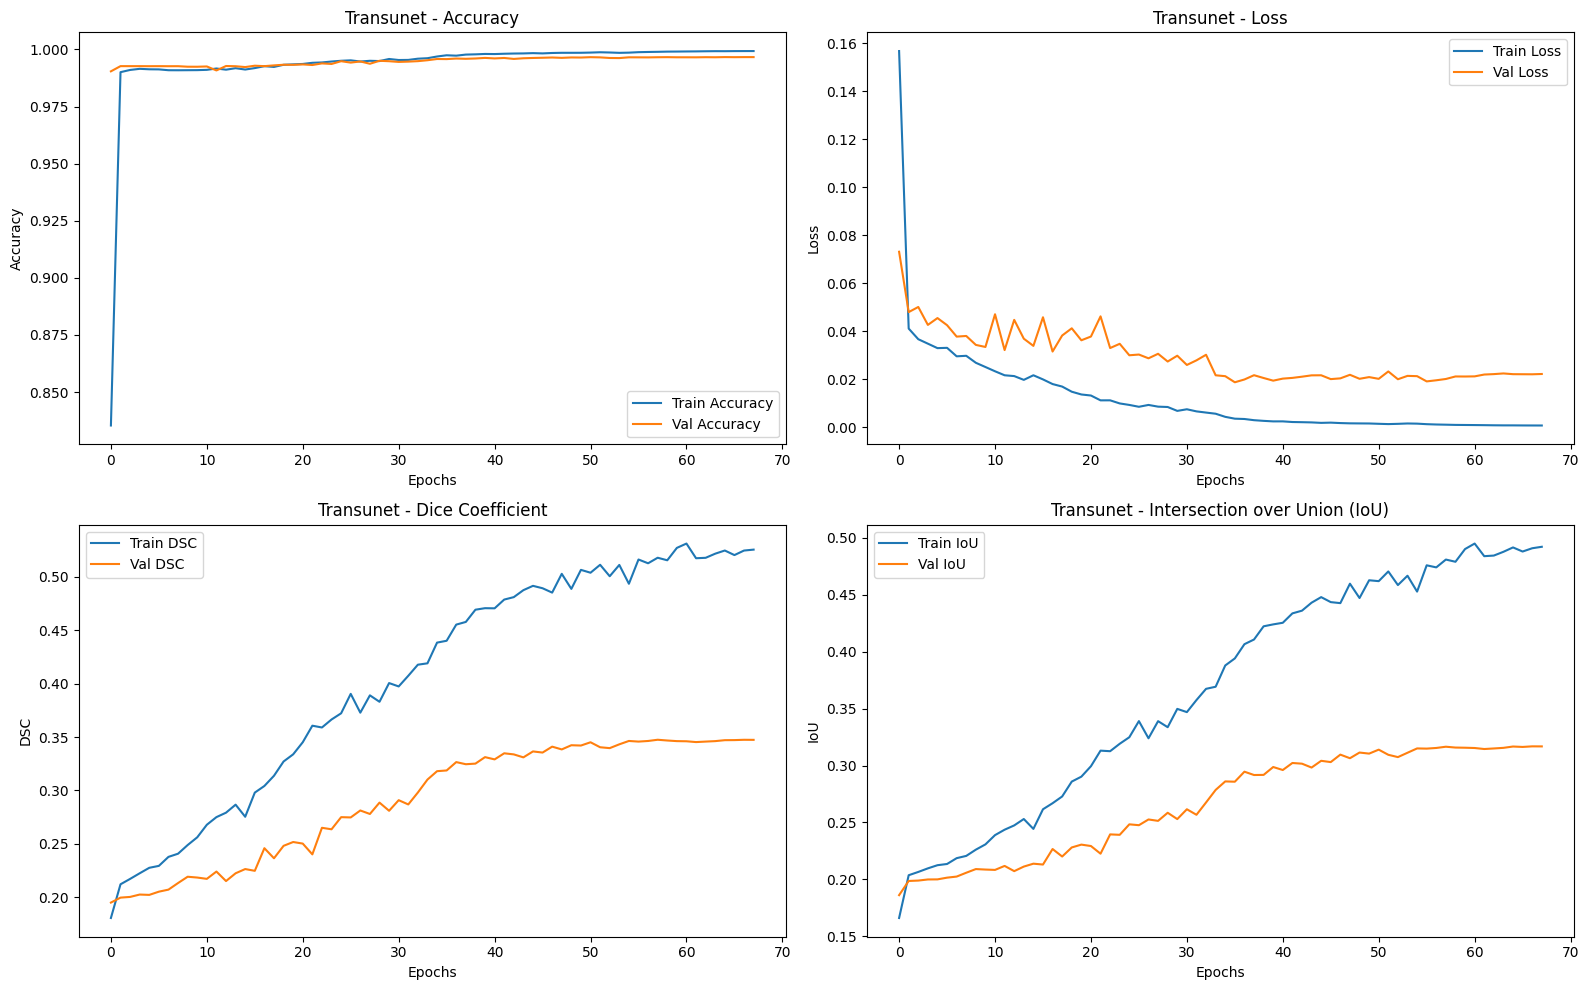

In [45]:
for history in [
                history_transunet_unet]: 
    plot_training_history(history, title=history.model.name)

# Testing

In [24]:
def mean_iou_per_class(model, dataset, num_classes=NUM_CLASSES):
    """
    Menghitung Mean IoU per kelas pada seluruh dataset.
    """
    total_intersection = np.zeros(num_classes)
    total_union = np.zeros(num_classes)

    for images, masks in dataset:
        preds = model.predict(images)
        y_pred = np.argmax(preds, axis=-1).reshape(-1)
        y_true = np.argmax(masks.numpy(), axis=-1).reshape(-1)  # or masks.numpy().reshape(-1) if already in int format
        for c in range(num_classes):
            true_c = (y_true == c)
            pred_c = (y_pred == c)
            intersection = np.logical_and(true_c, pred_c).sum()
            union = np.logical_or(true_c, pred_c).sum()
            total_intersection[c] += intersection
            total_union[c] += union

    mean_iou = np.divide(
        total_intersection,
        total_union,
        out=np.zeros_like(total_intersection, dtype=np.float32),
        where=total_union != 0
    )
    return mean_iou

In [42]:
results = model_transunet_unet.evaluate(test_ds)
print("Test loss:", results[0])
print("Test categorical_accuracyt:", results[1])
print("Test dice_coef:", results[2])
print("Test iou:", results[3])

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9920 - dsc: 0.3579 - iou: 0.3306 - loss: 0.0355
Test loss: 0.023091400042176247
Test categorical_accuracyt: 0.9955527186393738
Test dice_coef: 0.35260820388793945
Test iou: 0.3224397599697113


In [26]:
CLASS_MAPPING = {
    0: 'Background',
    1: 'ablation',
    2: 'breakdown',
    3: 'fracture',
    4: 'groove'
}

In [43]:
# Contoh penggunaan:
miou_per_class = mean_iou_per_class(model_transunet_unet, test_ds, num_classes=NUM_CLASSES)
for idx, name in CLASS_MAPPING.items():
    print(f"Mean IoU for class '{name}': {miou_per_class[idx]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Mean IoU for class 'Background': 0.9956
Mean IoU for class 'ablation': 0.5974
Mean IoU for class 'breakdown': 0.6900
Mean IoU for class 'fracture': 0.6658
Mean IoU for class 'groove': 0.3853


In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_and_plot_confusion(model, dataset, class_names):
    """
    Evaluasi model segmentasi:
    - Menampilkan test loss, accuracy, dice coef, dan mIoU
    - Menampilkan confusion matrix pixel-wise
    """

    # Hitung confusion matrix pixel-wise
    y_true_all, y_pred_all = [], []

    for images, masks in dataset:
        preds = model.predict(images)
        y_pred = np.argmax(preds, axis=-1).flatten()
        y_true = np.argmax(masks.numpy(), axis=-1).flatten()
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=range(len(class_names)))

    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Pixel-wise)')
    plt.tight_layout()
    plt.show()
    
      # Evaluasi model
    print(classification_report(
        y_true_all, y_pred_all,
        target_names=class_names,
        zero_division=0
    ))
    

In [31]:
class_names = ['Background', 'ablation', 'breakdown', 'fracture', 'groove']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


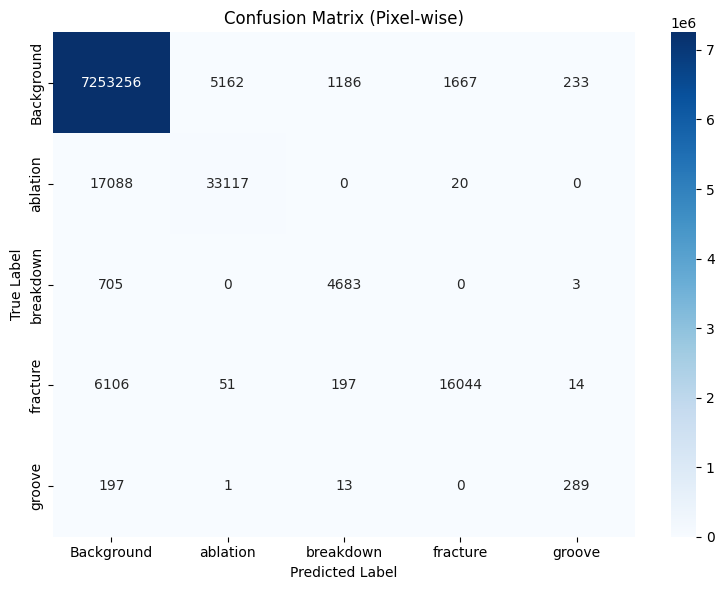

              precision    recall  f1-score   support

  Background       1.00      1.00      1.00   7261504
    ablation       0.86      0.66      0.75     50225
   breakdown       0.77      0.87      0.82      5391
    fracture       0.90      0.72      0.80     22412
      groove       0.54      0.58      0.56       500

    accuracy                           1.00   7340032
   macro avg       0.81      0.76      0.78   7340032
weighted avg       1.00      1.00      1.00   7340032



In [44]:
evaluate_model_and_plot_confusion(model_transunet_unet, test_ds, class_names)

# Visualisasi testing

In [ ]:
def overlay_mask_on_image(image, mask, class_names, alpha=0.5):
    """
    image: numpy array (H, W, 3), range [0, 1] or [0, 255]
    mask: numpy array (H, W), berisi index kelas (0=background, dst)
    class_names: list of str
    alpha: transparansi overlay
    """
    # Pastikan image dalam range [0, 1]
    if image.max() > 1.0:
        image = image / 255.0

    # Buat colormap
    cmap = plt.get_cmap('tab20', len(class_names))
    mask_rgb = cmap(mask)[..., :3]  # Ambil RGB saja

    # Overlay: background (0) tidak diwarnai
    mask_bool = mask > 0
    overlay = image.copy()
    overlay[mask_bool] = (1 - alpha) * image[mask_bool] + alpha * mask_rgb[mask_bool]
    return overlay

# Contoh penggunaan di fungsi predict_and_visualize:
def predict_and_visualize(model, image_path, input_size=(256, 256), class_names=None):
    img = load_img(image_path, target_size=input_size)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred_mask = model.predict(img_input)[0]  # shape: (H, W, C)
    mask_argmax = np.argmax(pred_mask, axis=-1)  # shape: (H, W)

    plt.figure(figsize=(18, 6))

    # Gambar asli
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    # Mask prediksi
    plt.subplot(1, 3, 2)
    if class_names is None:
        class_names = [f"Class {i}" for i in range(pred_mask.shape[-1])]
    cmap = plt.get_cmap('tab20', len(class_names))
    im = plt.imshow(mask_argmax, cmap=cmap, vmin=0, vmax=len(class_names)-1)
    plt.title("Predicted Mask")
    plt.axis("off")
    cbar = plt.colorbar(im, ticks=range(len(class_names)), fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(class_names)
    plt.clim(-0.5, len(class_names)-0.5)

    # Overlay
    plt.subplot(1, 3, 3)
    overlay = overlay_mask_on_image(img_array, mask_argmax, class_names, alpha=0.5)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Overlay mask ke atas gambar asli
def overlay_mask_on_image(image, mask, class_names, alpha=0.5):
    if image.max() > 1.0:
        image = image / 255.0

    cmap = plt.get_cmap('tab20', len(class_names))
    mask_rgb = cmap(mask)[..., :3]

    mask_bool = mask > 0
    overlay = image.copy()
    overlay[mask_bool] = (1 - alpha) * image[mask_bool] + alpha * mask_rgb[mask_bool]
    return overlay

# Visualisasi image + mask (true), pred mask, image + pred mask
def visualize_segmentation(image_array, pred_mask, true_mask=None, class_names=None):
    if class_names is None:
        num_classes = pred_mask.max() + 1 if true_mask is None else max(pred_mask.max(), true_mask.max()) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]

    cmap = plt.get_cmap('tab20', len(class_names))
    ncols = 3 if true_mask is not None else 2
    plt.figure(figsize=(6 * ncols, 6))

    if true_mask is not None:
        plt.subplot(1, ncols, 1)
        overlay_true = overlay_mask_on_image(image_array, true_mask, class_names, alpha=0.5)
        plt.imshow(overlay_true)
        plt.title("Image + True Mask")
        plt.axis("off")
        idx = 2
    else:
        idx = 1

    plt.subplot(1, ncols, idx)
    im = plt.imshow(pred_mask, cmap=cmap, vmin=0, vmax=len(class_names)-1)
    plt.title("Predicted Mask")
    plt.axis("off")
    cbar = plt.colorbar(im, ticks=range(len(class_names)), fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(class_names)
    plt.clim(-0.5, len(class_names)-0.5)

    plt.subplot(1, ncols, idx + 1)
    overlay_pred = overlay_mask_on_image(image_array, pred_mask, class_names, alpha=0.5)
    plt.imshow(overlay_pred)
    plt.title("Image + Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Prediksi dan visualisasi
def predict_and_visualize(model, image_path, input_size=(256, 256), class_names=None, true_mask=None):
    img = load_img(image_path, target_size=input_size)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    pred_mask = model.predict(img_input)[0]  # (H, W, C)
    pred_classes = np.argmax(pred_mask, axis=-1)  # (H, W)

    visualize_segmentation(img_array, pred_classes, true_mask=true_mask, class_names=class_names)

In [ ]:
CLASS_NAMES

In [ ]:
def load_true_mask(mask_path, target_size):
    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    mask_array = img_to_array(mask).squeeze().astype(np.uint8)  # shape: (H, W)
    return mask_array

# Direktori image dan mask
image_dir = f"{ROOT_DIR}/test/images"
mask_dir = f"{ROOT_DIR}/test/masks"

for img_file in os.listdir(image_dir):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):
        img_path = os.path.join(image_dir, img_file)

        # Ganti ekstensi ke .png jika mask disimpan dalam .png
        mask_file = os.path.splitext(img_file)[0] + ".png"
        mask_path = os.path.join(mask_dir, mask_file)

        # Cek apakah file mask ada
        if os.path.exists(mask_path):
            true_mask = load_true_mask(mask_path, target_size=(256, 256))
        else:
            print(f"WARNING: Mask not found for {img_file}, skipping true mask overlay.")
            true_mask = None

        print(f"Processing: {img_file}")
        predict_and_visualize(model_transunet_unet, img_path, input_size=(256, 256),
                              class_names=CLASS_NAMES + ["Background"], true_mask=true_mask)
